# MuJoCo Playground

This notebook concerns itself with preparing to model a cardiac catheter.


## Relevant Information

We attempt to model the catheter as a series of flexible hinges linked by stiff rods.

Reducing the length of the rods should get us closer to modelling the physics accurately.


# Imports

Run both of these cells:

In [1]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

In [6]:
#@title Other imports and helper functions

# General
import copy
import os
import time
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# VSCode doesn't support displaying using ffmpeg so we have to save our videos.
def display_video(frames, framerate=30, filepath = './video.mp4'):
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  writervideo = animation.FFMpegWriter(fps=60)
  anim.save(filepath, writer=writervideo)
  plt.close()
  return HTML(anim.to_html5_video())


# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

# Model definition, compilation and rendering



We begin by describing some basic concepts of the [MuJoCo](http://mujoco.org/) physics simulation library, but recommend the [official documentation](http://mujoco.org/book/) for details.

Let's define a simple model with two geoms and a light.

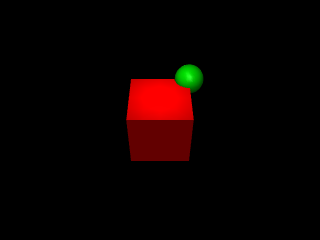

In [3]:
#@title A static model {vertical-output: true}

static_model = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(static_model)
pixels = physics.render()
PIL.Image.fromarray(pixels)

`static_model` is written in MuJoCo's XML-based [MJCF](http://www.mujoco.org/book/modeling.html) modeling language. The `from_xml_string()` method invokes the model compiler, which instantiates the library's internal data structures. These can be accessed via the `physics` object, see below.

## Adding DOFs and simulating, advanced rendering
This is a perfectly legitimate model, but if we simulate it, nothing will happen except for time advancing. This is because this model has no degrees of freedom (DOFs). We add DOFs by adding **joints** to bodies, specifying how they can move with respect to their parents. Let us add a hinge joint and re-render, visualizing the joint axis.

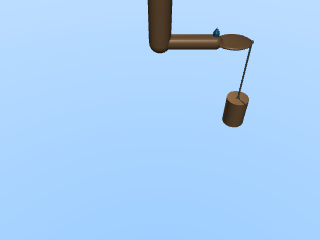

In [13]:
#@title A child body with a joint { vertical-output: true }

swinging_body = """<mujoco model = "example" >
    <compiler coordinate="global"/>
    <default>
        <geom rgba=".8 .6 .4 1"/>
    </default>
    <asset>
        <texture type="skybox" builtin="gradient" rgb1="1 1 1" rgb2=".6 .8 1"
                 width="256" height="256"/>
    </asset>
    <worldbody>
        <light pos="0 1 1" dir="0 -1 -1" diffuse="1 1 1"/>
        <body>
            <geom type="capsule" fromto="0 0 1  0 0 0.6" size="0.06"/>
            <joint type="ball" pos="0 0 1"/>
            <body>
                <geom type="capsule" fromto="0 0 0.6  0.3 0 0.6" size="0.04"/>
                <joint type="hinge" pos="0 0 0.6" axis="0 1 0"/>
                <joint type="hinge" pos="0 0 0.6" axis="1 0 0"/>
                <body>
                    <geom type="ellipsoid" pos="0.4 0 0.6" size="0.1 0.08 0.02"/>
                    <site name="end1" pos="0.5 0 0.6" type="sphere" size="0.01"/>
                    <joint type="hinge" pos="0.3 0 0.6" axis="0 1 0"/>
                    <joint type="hinge" pos="0.3 0 0.6" axis="0 0 1"/>
                </body>
            </body>
        </body>
        <body>
            <geom type="cylinder" fromto="0.5 0 0.2  0.5 0 0" size="0.07"/>
            <site name="end2" pos="0.5 0 0.2" type="sphere" size="0.01"/>
            <joint type="free"/>
        </body>
    </worldbody>
    <tendon>
        <spatial limited="true" range="0 0.6" width="0.005">
            <site site="end1"/>
            <site site="end2"/>
        </spatial>
    </tendon>
</mujoco>"""





"""
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">  
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

physics = mujoco.Physics.from_xml_string(swinging_body)
# Visualize the joint axis.
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

The things that move (and which have inertia) are called *bodies*. The body's child `joint` specifies how that body can move with respect to its parent, in this case `box_and_sphere` with respect to the `worldbody`. 

Note that the body's frame is **rotated** with an `euler` directive, and its children, the geoms and the joint, rotate with it. This is to emphasize the local-to-parent-frame nature of position and orientation directives in MJCF.

Let's make a video, to get a sense of the dynamics and to see the body swinging under gravity.

In [14]:
"""<mujoco model = "example" >
    <compiler coordinate="global"/>
    <default>
        <geom rgba=".8 .6 .4 1"/>
    </default>
    <asset>
        <texture type="skybox" builtin="gradient" rgb1="1 1 1" rgb2=".6 .8 1"
                 width="256" height="256"/>
    </asset>
    <worldbody>
        <light pos="0 1 1" dir="0 -1 -1" diffuse="1 1 1"/>
        <body>
            <geom type="capsule" fromto="0 0 1  0 0 0.6" size="0.06"/>
            <joint type="ball" pos="0 0 1"/>
            <body>
                <geom type="capsule" fromto="0 0 0.6  0.3 0 0.6" size="0.04"/>
                <joint type="hinge" pos="0 0 0.6" axis="0 1 0"/>
                <joint type="hinge" pos="0 0 0.6" axis="1 0 0"/>
                <body>
                    <geom type="ellipsoid" pos="0.4 0 0.6" size="0.1 0.08 0.02"/>
                    <site name="end1" pos="0.5 0 0.6" type="sphere" size="0.01"/>
                    <joint type="hinge" pos="0.3 0 0.6" axis="0 1 0"/>
                    <joint type="hinge" pos="0.3 0 0.6" axis="0 0 1"/>
                </body>
            </body>
        </body>
        <body>
            <geom type="cylinder" fromto="0.5 0 0.2  0.5 0 0" size="0.07"/>
            <site name="end2" pos="0.5 0 0.2" type="sphere" size="0.01"/>
            <joint type="free"/>
        </body>
    </worldbody>
    <tendon>
        <spatial limited="true" range="0 0.6" width="0.005">
            <site site="end1"/>
            <site site="end2"/>
        </spatial>
    </tendon>
</mujoco>"""

'<mujoco model = "example" >\n    <compiler coordinate="global"/>\n    <default>\n        <geom rgba=".8 .6 .4 1"/>\n    </default>\n    <asset>\n        <texture type="skybox" builtin="gradient" rgb1="1 1 1" rgb2=".6 .8 1"\n                 width="256" height="256"/>\n    </asset>\n    <worldbody>\n        <light pos="0 1 1" dir="0 -1 -1" diffuse="1 1 1"/>\n        <body>\n            <geom type="capsule" fromto="0 0 1  0 0 0.6" size="0.06"/>\n            <joint type="ball" pos="0 0 1"/>\n            <body>\n                <geom type="capsule" fromto="0 0 0.6  0.3 0 0.6" size="0.04"/>\n                <joint type="hinge" pos="0 0 0.6" axis="0 1 0"/>\n                <joint type="hinge" pos="0 0 0.6" axis="1 0 0"/>\n                <body>\n                    <geom type="ellipsoid" pos="0.4 0 0.6" size="0.1 0.08 0.02"/>\n                    <site name="end1" pos="0.5 0 0.6" type="sphere" size="0.01"/>\n                    <joint type="hinge" pos="0.3 0 0.6" axis="0 1 0"/>\n           

In [16]:
#@title Making a video {vertical-output: true}

duration = 10    # (seconds)
framerate = 30  # (Hz)

# Visualize the joint axis
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True

# Simulate and display video.
frames = []
physics.reset()  # Reset state and time
while physics.data.time < duration:
  physics.step()
  if len(frames) < physics.data.time * framerate:
    pixels = physics.render(scene_option=scene_option)
    frames.append(pixels)
display_video(frames, framerate)

: 

Note how we collect the video frames. Because physics simulation timesteps are generally much smaller than framerates (the default timestep is 2ms), we don't render after each step.

## Rendering options

Like joint visualisation, additional rendering options are exposed as parameters to the `render` method.

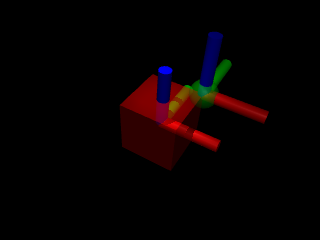

In [8]:
#@title Enable transparency and frame visualization {vertical-output: true}

scene_option = mujoco.wrapper.core.MjvOption()
scene_option.frame = enums.mjtFrame.mjFRAME_GEOM
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

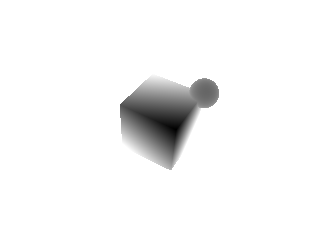

In [9]:
#@title Depth rendering {vertical-output: true}

# depth is a float array, in meters.
depth = physics.render(depth=True)
# Shift nearest values to the origin.
depth -= depth.min()
# Scale by 2 mean distances of near rays.
depth /= 2*depth[depth <= 1].mean()
# Scale to [0, 255]
pixels = 255*np.clip(depth, 0, 1)
PIL.Image.fromarray(pixels.astype(np.uint8))

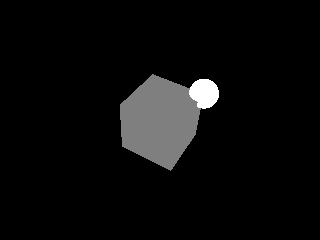

In [10]:
#@title Segmentation rendering {vertical-output: true}

seg = physics.render(segmentation=True)
# Display the contents of the first channel, which contains object
# IDs. The second channel, seg[:, :, 1], contains object types.
geom_ids = seg[:, :, 0]
# Infinity is mapped to -1
geom_ids = geom_ids.astype(np.float64) + 1
# Scale to [0, 1]
geom_ids = geom_ids / geom_ids.max()
pixels = 255*geom_ids
PIL.Image.fromarray(pixels.astype(np.uint8))


/Users/friedrichwilkegrosche/miniforge3/envs/hivemind/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


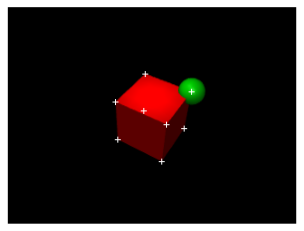

In [16]:
#@title Projecting from world to camera coordinates {vertical-output: true}

# Get the world coordinates of the box corners
box_pos = physics.named.data.geom_xpos['red_box']
box_mat = physics.named.data.geom_xmat['red_box'].reshape(3, 3)
box_size = physics.named.model.geom_size['red_box']
offsets = np.array([-1, 1]) * box_size[:, None]
xyz_local = np.stack(itertools.product(*offsets)).T
xyz_global = box_pos[:, None] + box_mat @ xyz_local

# Camera matrices multiply homogenous [x, y, z, 1] vectors.
corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
corners_homogeneous[:3, :] = xyz_global

# Get the camera matrix.
camera = mujoco.Camera(physics)
camera_matrix = camera.matrix

# Project world coordinates into pixel space. See:
# https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
xs, ys, s = camera_matrix @ corners_homogeneous
# x and y are in the pixel coordinate system.
x = xs / s
y = ys / s

# Render the camera view and overlay the projected corner coordinates.
pixels = camera.render()
fig, ax = plt.subplots(1, 1)
ax.imshow(pixels)
ax.plot(x, y, '+', c='w')
ax.set_axis_off()

In [11]:
#@title Adding arbitrary 3D geometry {vertical-output: true}

def get_geom_speed(physics, geom_name):
  """Returns the speed of a geom."""
  geom_vel = np.zeros(6)
  geom_type = mujoco.mjtObj.mjOBJ_GEOM
  geom_id = mujoco.mj_name2id(physics.model.ptr, geom_type, geom_name)
  mujoco.mj_objectVelocity(physics.model.ptr, physics.data.ptr,
                           geom_type, geom_id, geom_vel, 0)
  return np.linalg.norm(geom_vel)

def add_visual_capsule(scene, point1, point2, radius, rgba):
  """Adds one capsule to an mjvScene."""
  if scene.ngeom >= scene.maxgeom:
    return
  scene.ngeom += 1  # increment ngeom
  # initialise a new capsule, add it to the scene using mjv_makeConnector
  mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                      mujoco.mjtGeom.mjGEOM_CAPSULE, np.zeros(3),
                      np.zeros(3), np.zeros(9), rgba.astype(np.float32))
  mujoco.mjv_makeConnector(scene.geoms[scene.ngeom-1],
                           mujoco.mjtGeom.mjGEOM_CAPSULE, radius,
                           point1[0], point1[1], point1[2],
                           point2[0], point2[1], point2[2])

 # traces of time, position and speed
time = []
position = []
speed = []
offset = physics.model.jnt_axis[0]/8  # offset along the joint axis

def scene_callback(physics, scn):
  """Draw position trace, speed modifies width and colours."""
  if len(position) > 1:
    for i in range(len(position)-1):
      rgba=np.array((np.clip(speed[i]/10, 0, 1),
                     np.clip(1-speed[i]/10, 0, 1),
                     .5, 1.))
      radius=.003*(1+speed[i])
      point1 = position[i] + offset*time[i]
      point2 = position[i+1] + offset*time[i+1]
      add_visual_capsule(scn, point1, point2, radius, rgba)

duration = 6    # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []
physics.reset()  # Reset state and time
while physics.data.time < duration:
  # append data to the traces
  position.append(physics.named.data.geom_xpos["green_sphere"].copy())
  time.append(physics.data.time)
  speed.append(get_geom_speed(physics, "green_sphere"))
  physics.step()
  if len(frames) < physics.data.time * framerate:
    camera = mujoco.Camera(physics, max_geom=10000,
                           scene_callback=scene_callback)
    pixels = camera.render()
    frames.append(pixels)
display_video(frames, framerate, filepath = 'new_render.mp4')

# MuJoCo basics and named indexing

## `mjModel`
MuJoCo's `mjModel`, encapsulated in `physics.model`, contains the *model description*, including the default initial state and other fixed quantities which are not a function of the state, e.g. the positions of geoms in the frame of their parent body. The (x, y, z) offsets of the `box` and `sphere` geoms, relative their parent body `box_and_sphere` are given by `model.geom_pos`:

In [ ]:
physics.model.geom_pos

Docstrings of attributes provide short descriptions.

In [ ]:
help(type(physics.model).geom_pos)

The `model.opt` structure contains global quantities like

In [ ]:
print('timestep', physics.model.opt.timestep)
print('gravity', physics.model.opt.gravity)

## `mjData`
`mjData`, encapsulated in `physics.data`, contains the **state** and quantities that depend on it. The state is made up of time, generalized positions and generalised velocities. These are respectively `data.time`, `data.qpos` and `data.qvel`. 

Let's print the state of the swinging body where we left it:

In [ ]:
print(physics.data.time, physics.data.qpos, physics.data.qvel)

`physics.data` also contains **functions of the state**, for example the cartesian positions of objects in the world frame. The (x, y, z) positions of our two geoms are in `data.geom_xpos`:

In [ ]:
print(physics.data.geom_xpos)

## Named indexing

The semantics of the above arrays are made clearer using the `named` wrapper, which assigns names to rows and type names to columns.

In [ ]:
print(physics.named.data.geom_xpos)

Note how `model.geom_pos` and `data.geom_xpos` have similar semantics but very different meanings.

In [ ]:
print(physics.named.model.geom_pos)

Name strings can be used to index **into** the relevant quantities, making code much more readable and robust.

In [ ]:
physics.named.data.geom_xpos['green_sphere', 'z']

Joint names can be used to index into quantities in joint space (beginning with the letter `q`):

In [ ]:
physics.named.data.qpos['swing']

We can mix NumPy slicing operations with named indexing. As an example, we can set the color of the box using its name (`"red_box"`) as an index into the rows of the `geom_rgba` array. 

In [ ]:
#@title Changing colors using named indexing{vertical-output: true}

random_rgb = np.random.rand(3)
physics.named.model.geom_rgba['red_box', :3] = random_rgb
pixels = physics.render()
PIL.Image.fromarray(pixels)

Note that while `physics.model` quantities will not be changed by the engine, we can change them ourselves between steps.

## Setting the state with `reset_context()`

In order for `data` quantities that are functions of the state to be in sync with the state, MuJoCo's `mj_step1()` needs to be called. This is facilitated by the `reset_context()` context, please see in-depth discussion in Section 2.1 of the `dm_control` [tech report](https://arxiv.org/abs/2006.12983).

In [ ]:
physics.named.data.qpos['swing'] = np.pi
print('Without reset_context, spatial positions are not updated:',
      physics.named.data.geom_xpos['green_sphere', ['z']])
with physics.reset_context():
  physics.named.data.qpos['swing'] = np.pi
print('After reset_context, positions are up-to-date:',
      physics.named.data.geom_xpos['green_sphere', ['z']])

## Free bodies: the self-inverting "tippe-top"

A free body is a body with a `free` joint, with 6 movement DOFs: 3 translations and 3 rotations. We could give our `box_and_sphere` body a free joint and watch it fall, but let's look at something more interesting. A "tippe top" is a spinning toy which flips itself on its head ([Wikipedia](https://en.wikipedia.org/wiki/Tippe_top)). We model it as follows:

In [ ]:
#@title The "tippe-top" model{vertical-output: true}

tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015" 
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>
  
  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(tippe_top)
PIL.Image.fromarray(physics.render(camera_id='closeup'))

Note several new features of this model definition:
0. The free joint is added with the `<freejoint/>` clause, which is similar to `<joint type="free"/>`, but prohibits unphysical attributes like friction or stiffness.
1. We use the `<option/>` clause to set the integrator to the more accurate Runge Kutta 4th order.
2. We define the floor's grid material inside the `<asset/>` clause and reference it in the floor geom. 
3. We use an invisible and non-colliding box geom called `ballast` to move the top's center-of-mass lower. Having a low center of mass is  (counter-intuitively) required for the flipping behaviour to occur.
4. We save our initial spinning state as a keyframe. It has a high rotational velocity around the z-axis, but is not perfectly oriented with the world.
5. We define a `<camera>` in our model, and then render from it using the `camera_id` argument to `render()`.
Let us examine the state:

In [ ]:
print('positions', physics.data.qpos)
print('velocities', physics.data.qvel)

The velocities are easy to interpret, 6 zeros, one for each DOF. What about the length-7 positions? We can see the initial 2cm height of the body; the subsequent four numbers are the 3D orientation, defined by a *unit quaternion*. These normalized four-vectors, which preserve the topology of the orientation group, are the reason that `data.qpos` can be bigger than `data.qvel`: 3D orientations are represented with **4** numbers while angular velocities are **3** numbers.

In [12]:
#@title Video of the tippe-top {vertical-output: true}

duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
physics.reset(0)  # Reset to keyframe 0 (load a saved state).
while physics.data.time < duration:
  physics.step()
  if len(frames) < (physics.data.time) * framerate:
    pixels = physics.render(camera_id='closeup')
    frames.append(pixels)

display_video(frames, framerate)

ValueError: `keyframe_id` must be between 0 and -1 inclusive, got: 0.

### Measuring values from `physics.data`
The `physics.data` structure contains all of the dynamic variables and intermediate results produced by the simulation. These are expected to change on each timestep. 

Below we simulate for 2000 timesteps and plot the state and height of the sphere as a function of time.

In [ ]:
#@title Measuring values {vertical-output: true}

timevals = []
angular_velocity = []
stem_height = []

# Simulate and save data
physics.reset(0)
while physics.data.time < duration:
  physics.step()
  timevals.append(physics.data.time)
  angular_velocity.append(physics.data.qvel[3:6].copy())
  stem_height.append(physics.named.data.geom_xpos['stem', 'z'])

dpi = 100
width = 480
height = 640
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / second')

ax[1].plot(timevals, stem_height)
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('meters')
_ = ax[1].set_title('stem height')

# Example: A chaotic pendulum

Below is a model of a chaotic pendulum, similar to [this one](https://www.exploratorium.edu/exhibits/chaotic-pendulum) in the San Francisco Exploratorium. 

In [ ]:
#@title chaotic pendulum {vertical-output: true}
chaotic_pendulum = """
<mujoco>

  <option timestep=".001" >
    <flag energy="enable" contact="disable"/>
  </option>
  
  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>
  
  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>
    <body name="0" pos="0 0 .2">  
      <joint name="root"/>
      <geom fromto="-.2 0 0 .2 0 0" rgba="1 1 0 1"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>
      <body name="1" pos="-.2 0 0">  
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="1 0 0 1"/>
      </body>      
      <body name="2" pos=".2 0 0">  
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0 1"/>
      </body>
      <body name="3" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
      </body>      
    </body>
  </worldbody>
  
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(chaotic_pendulum)

pixels = physics.render(height=480, width=640, camera_id="fixed")
PIL.Image.fromarray(pixels)

## Timing
Let's see a video of it in action while we time the components:

In [ ]:
#@title physics vs. rendering: {vertical-output: true}


# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []

# set initial state
with physics.reset_context():
  physics.named.data.qvel['root'] = 10

# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
for i in range(n_frames):
  while physics.data.time * framerate < i:
    tic = time.time()
    physics.step()
    sim_time += time.time() - tic
    n_steps += 1
  tic = time.time()
  frame = physics.render(240, 320, camera_id="fixed")
  render_time += time.time() - tic
  frames.append(frame.copy())
    
# print timing and play video
print('simulation: {:6.2f} ms/frame ({:5.0f}Hz)'.format(
      1000*sim_time/n_steps, n_steps/sim_time))
print('rendering:  {:6.2f} ms/frame ({:5.0f}Hz)'.format(
      1000*render_time/n_frames, n_frames/render_time))
print('\n')

# show video
display_video(frames, framerate)

## Chaos
This is a [chaotic](https://en.wikipedia.org/wiki/Chaos_theory) system, small pertubations in initial conditions accumulate quickly:

In [ ]:
#@title chaos: sensitvity to pertubation {vertical-output: true}
PERTURBATION = 1e-7
SIM_DURATION = 10 # seconds
NUM_REPEATS = 8

# preallocate
n_steps = int(SIM_DURATION / physics.model.opt.timestep)
sim_time = np.zeros(n_steps)
angle = np.zeros(n_steps)
energy = np.zeros(n_steps)

# prepare plotting axes
_, ax = plt.subplots(2, 1, sharex=True)

# simulate NUM_REPEATS times with slightly different initial conditions
for _ in range(NUM_REPEATS):
  # initialize
  with physics.reset_context():
    physics.data.qvel[0] = 10 # root joint velocity
    # perturb initial velocities
    physics.data.qvel[:] += PERTURBATION * np.random.randn(physics.model.nv)

  # simulate
  for i in range(n_steps):
    physics.step()
    sim_time[i] = physics.data.time
    angle[i] = physics.named.data.qpos['root']
    energy[i] = physics.data.energy[0] + physics.data.energy[1]

  # plot
  ax[0].plot(sim_time, angle)
  ax[1].plot(sim_time, energy)

# finalize plot
ax[0].set_title('root angle')
ax[0].set_ylabel('radian')
ax[1].set_title('total energy') 
ax[1].set_ylabel('Joule')
ax[1].set_xlabel('second')
plt.tight_layout()

## Timestep and accuracy
__Q:__ Why is the energy varying at all? There is no friction or damping, this system should conserve energy. 

__A:__ Because of the discretization of time. 

If we decrease the timestep we'll get better accuracy, hence better energy conservation:

In [ ]:
#@title reducing the time-step: {vertical-output: true}
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -4, 5))

# prepare plotting axes
_, ax = plt.subplots(1, 1)

for dt in TIMESTEPS:
   # set timestep, print
  physics.model.opt.timestep = dt
  
  # allocate 
  n_steps = int(SIM_DURATION / physics.model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps)  
  
  # initialize
  with physics.reset_context():
    physics.data.qvel[0] = 9 # root joint velocity

  # simulate
  print('{} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    physics.step()
    sim_time[i] = physics.data.time
    energy[i] = physics.data.energy[0] + physics.data.energy[1]

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))
  
# finalize plot
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True);
plt.tight_layout()

## Timestep and divergence
When we increase the time step, the simulation quickly diverges

In [ ]:
#@title increasing the time-step: {vertical-output: true}
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -1.5, 7))

# get plotting axes
ax = plt.gca()

for dt in TIMESTEPS:
   # set timestep
  physics.model.opt.timestep = dt
  
  # allocate 
  n_steps = int(SIM_DURATION / physics.model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps) * np.nan
  speed = np.zeros(n_steps) * np.nan
  
  # initialize
  with physics.reset_context():
    physics.data.qvel[0] = 11 # root joint velocity

  # simulate
  print('{} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    try:
      physics.step()
    except BaseException:  # raises mujoco.engine.base.PhysicsError
      print('numerical divergence at timestep {}.'.format(i))
      break
    sim_time[i] = physics.data.time
    energy[i] = sum(abs(physics.data.qvel))
    speed[i] = np.linalg.norm(physics.data.qvel)

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))
  ax.set_yscale('log')


# finalize plot
ax.set_ybound(1, 1e3)
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()


# Contacts

In [ ]:
#@title 'box_and_sphere' free body: {vertical-output: true}

free_body_MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
    rgb2=".2 .3 .4" width="300" height="300" mark="edge" markrgb=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true" 
    reflectance=".2"/>
  </asset>

  <worldbody>
    <light pos="0 0 1" mode="trackcom"/>
    <geom name="ground" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid" solimp=".99 .99 .01" solref=".001 1"/>
    <body name="box_and_sphere" pos="0 0 0">  
      <freejoint/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1" solimp=".99 .99 .01"  solref=".001 1"/>
      <geom name="green_sphere" size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <camera name="fixed" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2"/>
      <camera name="track" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2" mode="track"/>
    </body>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(free_body_MJCF)


pixels = physics.render(400, 600, "fixed") 
PIL.Image.fromarray(pixels)

In [ ]:
#@title contacts in slow-motion: (0.25x){vertical-output: true}
n_frames = 200
height = 240
width = 320
frames = np.zeros((n_frames, height, width, 3), dtype=np.uint8)

# visualize contact frames and forces, make body transparent
options = mujoco.wrapper.core.MjvOption()
mujoco.wrapper.core.mjlib.mjv_defaultOption(options.ptr)
options.flags[enums.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[enums.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True

# tweak scales of contact visualization elements
physics.model.vis.scale.contactwidth = 0.1
physics.model.vis.scale.contactheight = 0.03
physics.model.vis.scale.forcewidth = 0.05
physics.model.vis.map.force = 0.3

# random initial rotational velocity:
with physics.reset_context():
  physics.data.qvel[3:6] = 5*np.random.randn(3)

# simulate and render
for i in range(n_frames):
  while physics.data.time < i/120.0: #1/4x real time
    physics.step()
  frames[i] = physics.render(height, width, camera_id="track", scene_option=options)
# show video
display_video(frames)

## Analysis of contact forces

In [ ]:
#@title contact-related quantities: {vertical-output: true}

n_steps = 499

# allocate
sim_time = np.zeros(n_steps)
ncon = np.zeros(n_steps)
force = np.zeros((n_steps,3))
velocity = np.zeros((n_steps, physics.model.nv))
penetration = np.zeros(n_steps)
acceleration = np.zeros((n_steps, physics.model.nv))
forcetorque = np.zeros(6)

# random initial rotational velocity:
with physics.reset_context():
  physics.data.qvel[3:6] = 2*np.random.randn(3)

# simulate and save data
for i in range(n_steps):
  physics.step()
  sim_time[i] = physics.data.time
  ncon[i] = physics.data.ncon
  velocity[i] = physics.data.qvel[:]
  acceleration[i] = physics.data.qacc[:]
  # iterate over active contacts, save force and distance
  for j,c in enumerate(physics.data.contact):
    mjlib.mj_contactForce(physics.model.ptr, physics.data.ptr, 
                          j, forcetorque)
    force[i] += forcetorque[0:3]
    penetration[i] = min(penetration[i], c.dist)
  # we could also do 
  # force[i] += physics.data.qfrc_constraint[0:3]
  # do you see why?
  
# plot
_, ax = plt.subplots(3, 2, sharex=True, figsize=(7, 10))

lines = ax[0,0].plot(sim_time, force)
ax[0,0].set_title('contact force')
ax[0,0].set_ylabel('Newton')
ax[0,0].legend(iter(lines), ('normal z', 'friction x', 'friction y'));

ax[1,0].plot(sim_time, acceleration)
ax[1,0].set_title('acceleration')
ax[1,0].set_ylabel('(meter,radian)/s/s')

ax[2,0].plot(sim_time, velocity)
ax[2,0].set_title('velocity')
ax[2,0].set_ylabel('(meter,radian)/s')
ax[2,0].set_xlabel('second')

ax[0,1].plot(sim_time, ncon)
ax[0,1].set_title('number of contacts')
ax[0,1].set_yticks(range(6))

ax[1,1].plot(sim_time, force[:,0])
ax[1,1].set_yscale('log')
ax[1,1].set_title('normal (z) force - log scale')
ax[1,1].set_ylabel('Newton')
z_gravity = -physics.model.opt.gravity[2]
mg = physics.named.model.body_mass["box_and_sphere"] * z_gravity
mg_line = ax[1,1].plot(sim_time, np.ones(n_steps)*mg, label='m*g', linewidth=1)
ax[1,1].legend()
  
ax[2,1].plot(sim_time, 1000*penetration)
ax[2,1].set_title('penetration depth')
ax[2,1].set_ylabel('millimeter')
ax[2,1].set_xlabel('second')
    
plt.tight_layout()

## Friction

In [ ]:
#@title tangential friction and slope: {vertical-output: true}
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="6 6" 
     texuniform="true" reflectance=".2"/>
     <material name="wall" rgba='.5 .5 .5 1'/>
  </asset>

  <default>
    <geom type="box" size=".05 .05 .05" />
    <joint type="free"/>
  </default>

  <worldbody>
    <light name="light" pos="-.2 0 1"/>
    <geom name="ground" type="plane" size=".5 .5 10" material="grid" 
     zaxis="-.3 0 1" friction=".1"/> 
    <camera name="y" pos="-.1 -.6 .3" xyaxes="1 0 0 0 1 2"/>
    <body pos="0 0 .1">
      <joint/>
      <geom/>
    </body>
    <body pos="0 .2 .1">
      <joint/>
      <geom friction=".33"/>
    </body>    
  </worldbody>
  
</mujoco>
"""
# load 
physics = mujoco.Physics.from_xml_string(MJCF)

n_frames = 60
height = 480
width = 480
video = np.zeros((n_frames, height, width, 3), dtype=np.uint8)

# simulate and render
physics.reset()
for i in range(n_frames):
  while physics.data.time < i/30.0:
    physics.step()
  video[i] = physics.render(height, width, "y")
display_video(video)

# Actuators and tendons

In [ ]:
#@title bat and piñata: {vertical-output: true}
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="1 1" 
     texuniform="true" reflectance=".2"/>
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1"/>
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>
    <site name="anchor" pos="0 0 .3" size=".01"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>  
  
    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>  
    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04" 
       size=".04" rgba="0 0 1 1"/>
    </body>
    
    <body name="box_and_sphere" pos="0 0 0">  
      <joint name="free" type="free"/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/>
      <geom name="green_sphere"  size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <site name="hook" pos="-.1 -.1 -.1" size=".01"/>
    </body>
  </worldbody>
  
  <tendon>
    <spatial name="wire" limited="true" range="0 0.35" width="0.003">
      <site site="anchor"/>
      <site site="hook"/>
    </spatial>    
  </tendon>
  
  <actuator>
    <motor name="my_motor" joint="swing" gear="1"/>
  </actuator>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(MJCF)
PIL.Image.fromarray(physics.render(480, 480, "fixed") )


In [ ]:
#@title actuated bat and passive piñata: {vertical-output: true}
n_frames = 180
height = 240
width = 320
video = np.zeros((n_frames, height, width, 3), dtype=np.uint8)

# constant actuator signal
with physics.reset_context():
  physics.named.data.ctrl["my_motor"] = 20

# simulate and render
for i in range(n_frames):
  while physics.data.time < i/30.0:
    physics.step()
  video[i] = physics.render(height, width, "fixed")

display_video(video)

Let's ignore the actuator and apply forces directly to the body:

In [ ]:
#@title actuated piñata: {vertical-output: true}
n_frames = 300
height = 240
width = 320
video = np.zeros((n_frames, height, width, 3), dtype=np.uint8)

# constant actuator signal
physics.reset()

# gravity compensation
mg = -(physics.named.model.body_mass["box_and_sphere"] * 
       physics.model.opt.gravity[2])
physics.named.data.xfrc_applied["box_and_sphere", 2] = mg

# One Newton in the x direction
physics.named.data.xfrc_applied["box_and_sphere", 0] = 1

# simulate and render
for i in range(n_frames):
  while physics.data.time < i/30.0:
    physics.step()
  video[i] = physics.render(height, width)
display_video(video)

# Kinematic Jacobians
A __Jacobian__ is a derivative matrix of a vector-valued function. MuJoCo computes the Jacobians of all transformations between joint space and Cartesian space.

Below we use the Jacobian of the end effector position to create a virtual spring to some random target.

In [ ]:
#@title virtual spring-damper: {vertical-output: true}
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="6 6" 
     texuniform="true" reflectance=".2"/>
     <material name="wall" rgba='.5 .5 .5 1'/>
  </asset>

  <option gravity="0 0 0">
    <flag contact="disable"/>
  </option>

  <default>
    <geom type="capsule" size=".02 .02 .02" />
    <joint type="hinge" damping=".02"/>
  </default>

  <worldbody>
    <light name="light" pos="0 0 1"/>
    <geom name="ground" type="plane" size=".5 .5 10" material="grid"/> 
    <camera name="y" pos="0 -.8 .6" xyaxes="1 0 0 0 1 2"/>
    <camera name="x" pos="-.8 0 .6" xyaxes="0 -1 0 1 0 2"/>

    <geom fromto="0 0 0 0 0 .2" />
    <body pos="0 0 .2">
      <joint axis="0 0 1"/>
      <joint axis="0 1 0"/>
      <geom fromto="0 0 0 .2 0 0" />
      <body pos=".2 0 0">
        <joint axis="1 0 0"/>
        <joint axis="0 1 0"/>
        <geom fromto="0 0 0 0 0 .15" />
        <body pos="0 0 .15">
          <joint axis="0 0 1"/>
          <joint axis="0 1 0"/>
          <geom fromto="0 0 0 .1 0 0"/>
          <geom name="fingertip" type="box" pos=".1 0 0" rgba="1 0 0 1" />
        </body>        
      </body>
    </body>
  
  <geom name="target" type="box" rgba="0 1 0 1"/>
  
  </worldbody>
  
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(MJCF)

# virtual spring coefficient
KP = 3

# prepare simulation
jac_pos = np.zeros((3, physics.model.nv))
jac_rot = np.zeros((3, physics.model.nv))

n_frames = 50
height = 320  
width = 320
video = np.zeros((n_frames, height, 2*width, 3), dtype=np.uint8)

# place target in random location
with physics.reset_context():
  target_pos = np.random.rand(3)*.5
  target_pos[:2] -= .25
  physics.named.model.geom_pos["target"][:] = target_pos
  physics.named.model.geom_sameframe["target"] = 0

# simulate and render
for i in range(n_frames):
  while physics.data.time < i/15.0:
    
    # get Jacobian of fingertip position
    mjlib.mj_jacGeom(physics.model.ptr, 
                     physics.data.ptr, 
                     jac_pos, 
                     jac_rot, 
                     physics.model.name2id('fingertip', 'geom'))
    # multiply the jacobian by error to get vector in joint space
    err = (physics.named.data.geom_xpos["target"] - 
           physics.named.data.geom_xpos["fingertip"])
    jnt_err = np.dot(err, jac_pos)
    
    # set virutal spring force
    physics.data.qfrc_applied[:] = KP * jnt_err
    
    # step
    physics.step()

  video[i] = np.hstack((physics.render(height, width, "y"),
                        physics.render(height, width, "x")))

display_video(video, framerate=24)